# Digit recognizer

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



Using TensorFlow backend.


In [2]:
train = train.values
test = test.values

X = train[:,1:]
Y = train[:,0]

X = np.reshape(X, (X.shape[0], 28, 28))
X = np.expand_dims(X, axis=3)

Y = np.reshape(Y, (-1, 1))
encoder = LabelBinarizer().fit(Y)
Y = encoder.transform(Y)

test = np.reshape(test, (test.shape[0], 28, 28))
test = np.expand_dims(test, axis=3)

print(X.shape, Y.shape, test.shape)

X = X/255.0
test = test/255.0

(42000, 28, 28, 1) (42000, 10) (28000, 28, 28, 1)


In [3]:
def model(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(20, (5, 5), strides = (1, 1), padding='same')(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(X)
    
    X = Conv2D(50, (5, 5), strides = (1, 1), padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(500, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

digit = model((28, 28, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
digit.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Learning rete reduction
cb = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, \
                        verbose=0, mode='auto', epsilon=0.001, cooldown=0, min_lr=0.000001)

# Data augmentation
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None)

datagen.fit(X_train)


history = digit.fit_generator(datagen.flow(X_train, Y_train, batch_size=50), steps_per_epoch=len(X_train)/50, \
                    validation_data=(X_test, Y_test), epochs=20, callbacks=[cb])        
    
    

/Users/bai/anaconda/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (37800, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/20
756/756 [==============================] - 116s - loss: 0.2334 - acc: 0.9253 - val_loss: 0.0630 - val_acc: 0.9807
Epoch 2/20
756/756 [==============================] - 112s - loss: 0.0884 - acc: 0.9720 - val_loss: 0.0457 - val_acc: 0.9867
Epoch 3/20
756/756 [==============================] - 110s - loss: 0.0726 - acc: 0.9781 - val_loss: 0.0363 - val_acc: 0.9905
Epoch 4/20
756/756 [==============================] - 110s - loss: 0.0641 - acc: 0.9797 - val_loss: 0.0353 - val_acc: 0.9898
Epoch 5/20
756/756 [==============================] - 102s - loss: 0.0585 - acc: 0.9824 - val_loss: 0.0309 - val_acc: 0.9907
Epoch 6/20
756/756 [==============================] - 337s - loss: 0.0558 - acc: 0.9826 - val_loss: 0.0566 - val_acc: 0.9819
Epoch 7/20
756/756 [==============================] - 116s - loss: 0.0551 - acc: 0.9833 - val_loss: 0.0397 - val_acc: 0.9902
Epoch 8/20
756/756 [==============================] - 105s - loss: 0.0342 - acc: 0.9896 - val_loss: 0.0281 - val_acc: 0.9917


In [4]:
result = digit.predict(test)
result = encoder.inverse_transform(result)
print(result.shape)

(28000,)


In [5]:
imageId = [i for i in range(1, result.shape[0]+1)]
submit = pd.DataFrame({'ImageId':imageId, 'Label':result})
submit.to_csv('submit.csv', index=False)

# Analysis

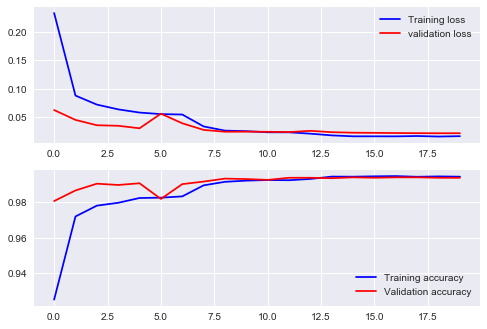

In [11]:
import matplotlib.pyplot as plt
import seaborn as sna

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

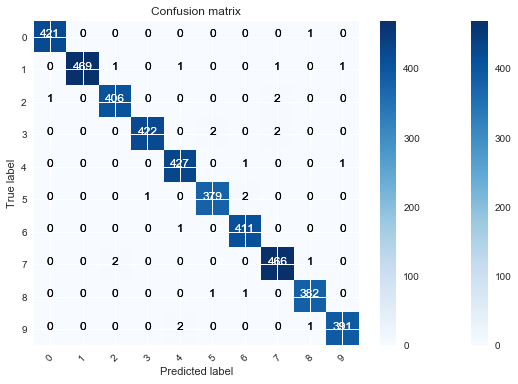

In [15]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predict the values from the validation dataset
Y_pred = digit.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

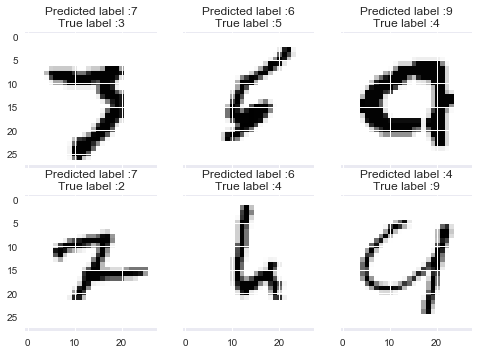

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)